# 폐렴(Pneumonia) 진단기

## 목차

 1. set-up
 
  * 패키지들을 import하는 작업
  
  
 2. 데이터 가져오기
 
  * 이미 있는 데이터들을 train, val, test로 나누어 가지고 옴
  
  
 3. 데이터 시각화
 
  * show_batch() 함수를 이용 normal 사진과 pneumonia의 사진을 확인
 
 
 4. CNN 모델링
 
  * 모델링을 통해 이미지 처리에 특화 시킴
  
  
 5. 데이터 imbalance 처리
 
  * normal 데이터와 pneumonia 데이터의 balance가 맞지 않기에 Weight balancing을 통해     balance를 맞춰줌
  
  
 6. 모델 훈련
 
  * loss와 optimizer, metrics를 설정
  
  * 모델을 fit 해준 후 학습
  
  
 7. 결과 확인
 
  * 시각적 그래프로 acc와 precision, recall을 확인
  
  * 그 후 test데이터를 이용해 모델 평가
  
  
 8. 파라미터 및 모델 수정 후 재 훈련
 
  * acc및 precision,recall을 높이기 위해 파라미터 및 모델을 수정
  
  ---

# 1. Set-up

### 라이브러리 import

In [30]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
from tensorflow.keras.utils import plot_model

### 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 변경할 파라미터 값
BATCH_SIZE = 32
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* train : 5216
* val : 16
* test : 624
 
#### val의 개수가 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옴 

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### train : val을 80:20으로 분할

* train : 4185
* val : 1047

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


### 정상 이미지와 폐렴 이미지를 경로안에 있는 단어를 이용해 셀 수 있게 함

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


#### 정상 이미지보다 폐렴 이미지가 약 3배정도 더 많은 것을 볼 수 있음

#### 차후에 imbalance 조정 예정

---

### 시간을 절약하면서 정확성을 위해 mini-batch 사용

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨 데이터가 따로 없음
### 경로에 있는 단어를 이용 라벨 데이터를 만들어 줌

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지 데이터는 사이즈가 제각각일 가능성이 높음

### 사이즈 통일을 위해 사이즈를 조정해줌

In [10]:
# 이미지를 알맞은 형식으로 바꿈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

### 리사이즈와 라벨 확인

In [12]:
for image, label in train_ds.take(2): # 2개의 데이터를 확인함
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


#### 사이즈가 설정한 사이즈로 통일, 라벨링도 True,False로 잘 설정

----

### test데이터도 위와 동일하게 생성

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 파이프라인을 이용해 학습 데이터를 효율적으로 사용

#### shuffle() : 고정 크기 버퍼 유지 후 해당 버퍼에서 무작위로 균일하게 다음 요소 선택

#### repeat() : epoch를 진행하면서 여러 번의 데이터셋을 불러옴(자동으로 데이터를 맞춰줌)

#### batch() :batch_size에서 정한 만큼의 배치를 줌

#### prefetch() : 첫 번째 데이터를 GPU에서 학습 하는 중에 두 번째 데이터를 CPU에서 준비함으로 리소스의 유휴 상태를 줄임(Idle Situation X)

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)


###  augmentation 기법을 사용
### 의료 영상같은 경우 노이즈나 위아래 플립은 오히려 악영향을 줄 수 있기에 좌우반전 정도로만 사용

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

# 3. 데이터 시각화

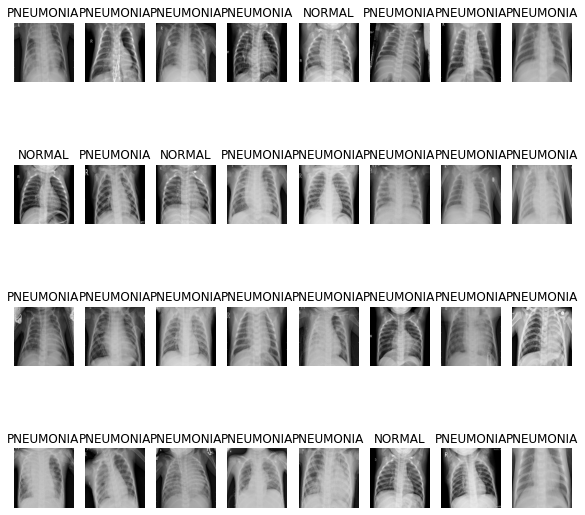

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

### Conv_block과 Dense_block을 생성

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 여기서 2가지의 regularizaition 기법이 사용되고 있음(BatchNormalization, Dropout)

#### 2가지의 기법을 동시에 쓰는 걸  금기하는 견해와 더 좋다는 견해로 나뉘기 때문에 현재는 2가지를 다 사용하고 수정을 통해 더 좋은 모델을 설정

## 모델 구현

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = build_model()

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

# 5. 데이터 imbalance 처리

### 폐렴 데이터가 노멀 데이터보다 3배 더 많은 상태

### imbalance는 학습에 있어 좋지 않기 때문에 Weight balancing 테크닉을 통해 특정 클래스 데이터에 더 큰 loss 값을 갖도록 가중치를 부여함

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


#### nomal 데이터는 1.96의 가중치를 pneumonia 데이터는 0.67의 가중치를 준다는 것을 볼 수 있음

---

# 6. 모델 훈련

### GPU를 선택 후

#### 라벨이 2개 이므로 'binary_crossentropy' loss를 사용
#### optimizer는 'adam'
#### metrics는 'accuracy' , 'precision' , 'recall'을 사용

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### model fit

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 67s 405ms/step - loss: 0.4190 - accuracy: 0.7834 - precision: 0.9500 - recall: 0.7484 - val_loss: 0.5943 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 54s 414ms/step - loss: 0.2108 - accuracy: 0.9221 - precision: 0.9793 - recall: 0.9148 - val_loss: 0.8076 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 54s 414ms/step - loss: 0.1580 - accuracy: 0.9397 - precision: 0.9831 - recall: 0.9352 - val_loss: 0.9278 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 55s 422ms/step - loss: 0.1526 - accuracy: 0.9445 - precision: 0.9811 - recall: 0.9433 - val_loss: 1.3491 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 56s 435ms/step - loss: 0.1175 - accura

# 7. 결과 확인

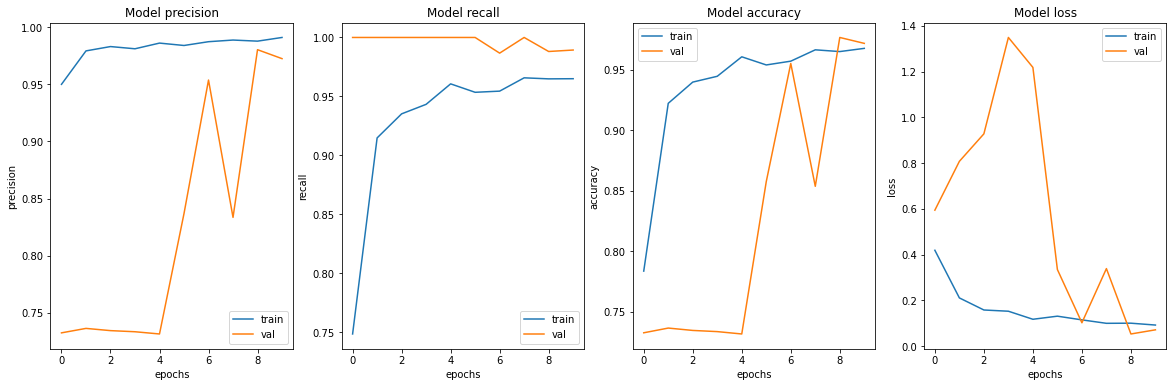

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가(test)

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 216ms/step - loss: 0.8941 - accuracy: 0.7452 - precision: 0.7112 - recall: 0.9974
Loss: 0.8941177725791931,
Accuracy: 0.745192289352417,
Precision: 0.7111517190933228,
Recall: 0.9974358677864075


### 정확도는 약 74%로  현직 의사분들의 정확도인 90%와 16%정도 차이가 난다고 볼 수 있다.

### 여기서 Precision은 정밀도로 모델이 True라고 분류한 것 중 실제 True인 것의 비율이다.

### Recall은 재현율으로 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율을 말한다.

--- 

### 즉, 실제 폐렴인 것 중 모델이 양성이라고 예측한 확률은 약 99%로 굉장히 높지만, 모델이 양성이라고 했지만 실제 폐렴인 확률은 71%로 상대적으로 낮다고 할 수 있다.

---

# 8. 파라미터 및 모델 수정 후 재 훈련

## 모델 구현

### 모델을 Resnet-18로 구현해 다시 학습을 시켜보도록 하자

### ResNet의 특징은 skip connection이다.

In [53]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Residual Block 정의
def residual_block(x, filters, kernel_size=3, stride=1):
    identity = x

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    # stride가 1이 아니거나 identity의 채널 수가 filters와 다른 경우는 1x1 convolution
    # 을 사용하여 채널 수 를 조절함
    if stride != 1 or identity.shape[-1] != filters:
        identity = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(identity)
        identity = BatchNormalization()(identity)

    x = tf.keras.layers.add([x, identity])
    x = tf.keras.layers.ReLU()(x)
    return x

# ResNet18 아키텍처 정의
def ResNet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# 모델 생성
input_shape = (180, 180, 3)
num_classes = 1
model = ResNet18(input_shape, num_classes)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 90, 90, 64)   9472        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_133 (BatchN (None, 90, 90, 64)   256         conv2d_123[0][0]                 
__________________________________________________________________________________________________
re_lu_99 (ReLU)                 (None, 90, 90, 64)   0           batch_normalization_133[0][0]    
____________________________________________________________________________________________

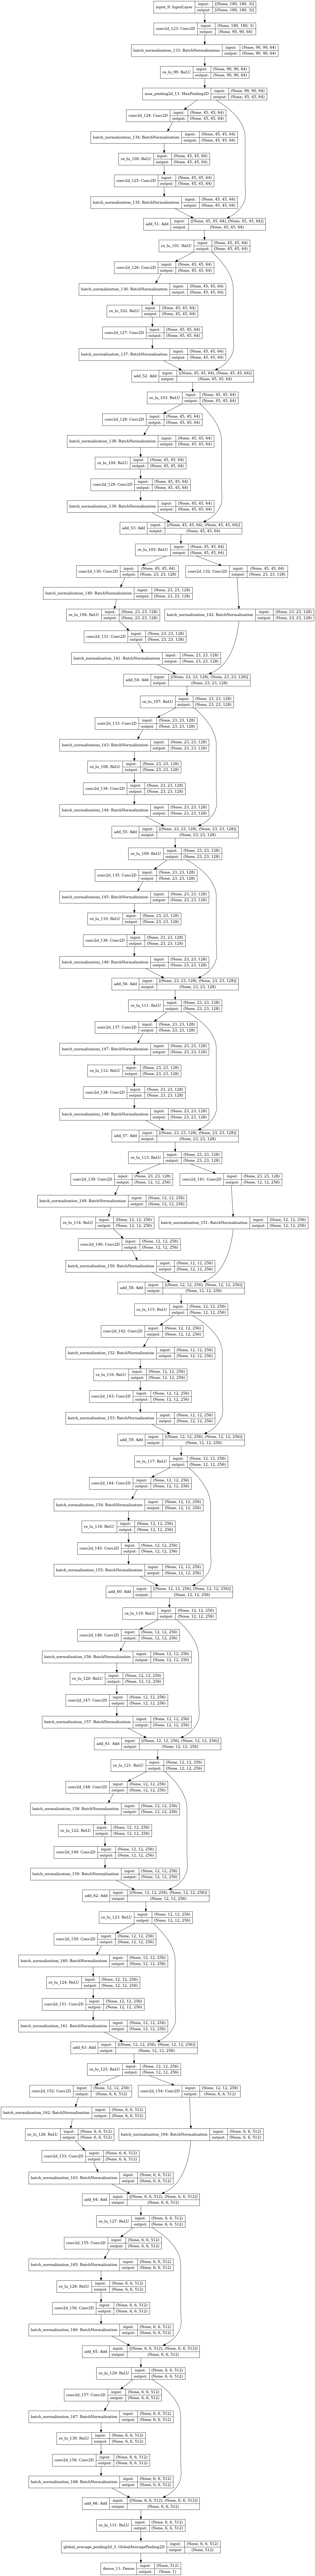

In [54]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

## 모델 훈련

In [55]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

## model fit

In [56]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 63s 396ms/step - loss: 0.3293 - accuracy: 0.8921 - precision: 0.9633 - recall: 0.8889 - val_loss: 1.1196 - val_accuracy: 0.5693 - val_precision: 0.9588 - val_recall: 0.4329
Epoch 2/10
130/130 [==============================] - 51s 395ms/step - loss: 0.1641 - accuracy: 0.9361 - precision: 0.9774 - recall: 0.9356 - val_loss: 2.7945 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 51s 394ms/step - loss: 0.1589 - accuracy: 0.9421 - precision: 0.9802 - recall: 0.9413 - val_loss: 0.7163 - val_accuracy: 0.7793 - val_precision: 0.7690 - val_recall: 0.9987
Epoch 4/10
130/130 [==============================] - 52s 400ms/step - loss: 0.1089 - accuracy: 0.9572 - precision: 0.9857 - recall: 0.9563 - val_loss: 9.2153 - val_accuracy: 0.2656 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 5/10
130/130 [==============================] - 53s 413ms/step - loss: 0.1182 - accura

## 결과확인

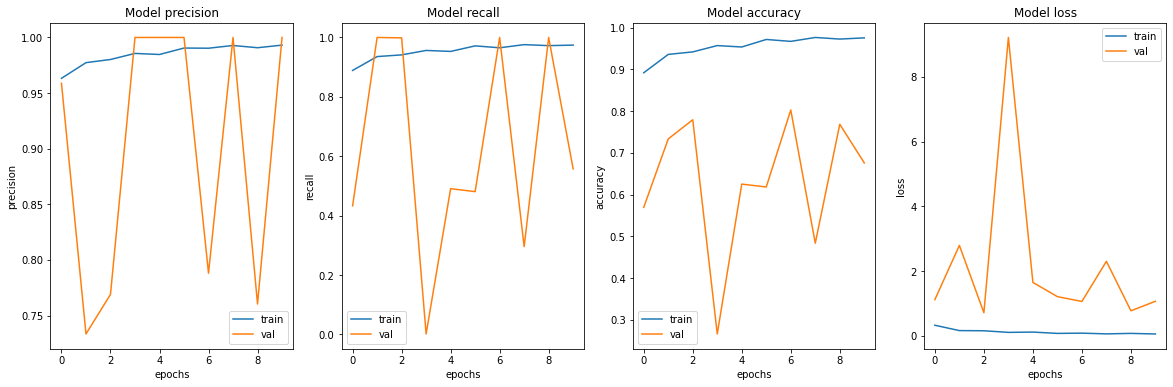

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 이게 맞나 싶지만 밸리데이션 값이 날뛰고 있다.

In [61]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 205ms/step - loss: 0.6561 - accuracy: 0.7676 - precision: 0.9391 - recall: 0.6718
Loss: 0.6561049222946167,
Accuracy: 0.7676281929016113,
Precision: 0.939068078994751,
Recall: 0.6717948913574219


### 그런데 짜잔 acc 값은 2%가 올랐다.

### 대신 재현율 값은 곤두박질 쳤고 정밀도 값이 93%로 많이 올라간걸 볼 수 있다.

# 회고

### 이번에 프로젝트를 하면서 느낀 건 물론 내가 잘 못하는 것도 있지만 커널이 너무 많이 죽는다. 특히나 이미지 구현하는 것에 있어서 배치 사이즈를 16에서 32로 올렸음에도 불구하고 안된다고 한다던지 어쩔 땐 되다가 어쩔 땐 오류가나는 경우가 너무 많고 커널이 죽는 바람에 다시 all run을 해야하다 보니 에폭을 다시 돌리는 경우가 있어 너무 많은 시간을 쓰게 된다

### 배치 사이즈를 16으로 시작을 하는데도 커널이 죽는 경우가 있어서 이러면 배치사이즈를 줄이는 것도 안될 뿐더러 러닝에서 나머지 하고 있는 터미널을 셧다운 하는 것 또한 지금 하는 것이 폐렴 프로젝트라 하나 밖에 없는데 이것또한 근본적인 해결책은 아닌거 같다.

### 아예 커널을 다시 시작해서 돌리는 것은 잘되지만 수정하는 파트에서 수정을 하고 다시 돌리면 에러가 뜨고 수정을 다시 원복해도 오류가 지속되면서 커널이 죽어버리니 사실 수정을 많이 할 수가 없었고 여러가지 수정을 할 수 없었다.

### 배치 사이즈도 원래는 16으로 시작해서 여러개의 배치 사이즈를 넣어 보려 했으나 어그멘트에서 계속 차원이 5차원으로 오류가 나서 결국엔 제일 처음 배치 사이즈를 32로 해줬더니 오류가 나지 않는다. 왜 수정을 해서 넣으면 오류가 나고 처음에 32로 주면 오류가 나지 않는 건지 잘 모르겠다. 바꾼 코드는 단 하나도 없고 단지 배치사이즈만 바꾼 것인데 말이다.

### 그런 것을 제외하고는 꽤 재밌는 프로젝트 였던 것 같다. 폐렴을 구별하는 것은 시그모이드를 이용해 이진 분류를 하는 것이고 또한 간단한 의료지식도 알게되어서 나름 유용하게 사용할 수 있을 것 같다. 

### ResNet또한 GPT의 도움을 좀 받기는 했지만 구현해 볼 수 있어서 좋았고 커널이 계속 죽지 않았더라면 좀 더 여러가지 파라미터와 배워본 것들을 해 볼 수 있었을 텐데 좀 아쉬운 생각또한 들었다.

### 참고 : ResNet18 구현 - ChatGPT